In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT=os.getenv("LANGCHAIN_PROJECT")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"]= GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"]=LANGCHAIN_PROJECT

In [3]:
def function_1(input_1):
    return input_1 + " First Function "

def function_2(input_2):
    return input_2 + "to Second Function"

In [5]:
from langgraph.graph import Graph

# Define a Langchain graph
workflow = Graph()

workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge('node_1', 'node_2')

workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

app = workflow.compile()

In [6]:
app.invoke('I am moving from')

'I am moving from First Function to Second Function'

In [7]:
input = 'I am moving from'
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'node_1':
---
I am moving from First Function 

---

Output from node 'node_2':
---
I am moving from First Function to Second Function

---



### Integrating LLM call in the LangGraph

In [8]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")
llm.invoke("hi")

AIMessage(content='Hi there! 👋\n\nWhat can I do for you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 11, 'total_tokens': 28, 'completion_time': 0.030909091, 'prompt_time': 0.001919478, 'queue_time': 0.23072616099999999, 'total_time': 0.032828569}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-442ec83f-944b-4e0d-a8fe-062b6c34c29c-0', usage_metadata={'input_tokens': 11, 'output_tokens': 17, 'total_tokens': 28})

In [9]:
def function_1(input_1):
    complete_query = "Your task is to provide only the topic based on the user query. \
        Only output the topic among: [Japan , Sports]. Don't include reasoning. Following is the user query: " + input_1
    response = llm.invoke(complete_query)
    return response.content

def function_2(input_2):
    TOPIC_UPPER = input_2.upper()
    response = f"Here is the topic in UPPER case: {TOPIC_UPPER}"
    return response

In [10]:
# Define a Langchain graph
workflow = Graph()

workflow.add_node("Agent", function_1)
workflow.add_node("tool", function_2)

workflow.add_edge('Agent', 'tool')

workflow.set_entry_point("Agent")
workflow.set_finish_point("tool")

app = workflow.compile()

In [11]:
query = "Tell me about Japan's Industrial Growth"
app.invoke(query)

'Here is the topic in UPPER case: JAPAN \n'

In [12]:
for output in app.stream(query):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'Agent':
---
Japan 


---

Output from node 'tool':
---
Here is the topic in UPPER case: JAPAN 


---



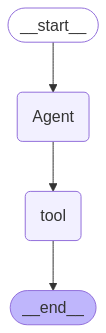

In [13]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### RAG Pipline

In [14]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

c:\Users\JAGADEESHNAIKPALTHYA\langgraph-end-to-end\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [16]:
llm.invoke('Hii How are you')

AIMessage(content="I'm doing well, thank you! As an AI, I don't have feelings, but I'm ready to assist you with any questions or tasks you may have.\n\nHow can I help you today?\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 13, 'total_tokens': 61, 'completion_time': 0.087272727, 'prompt_time': 0.001901197, 'queue_time': 0.234063152, 'total_time': 0.089173924}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-f1cd62ea-58c5-42d7-8cab-f956a6feb5fd-0', usage_metadata={'input_tokens': 13, 'output_tokens': 48, 'total_tokens': 61})

In [17]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [18]:
loader=DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=50
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [21]:
db = Chroma.from_documents(new_docs, embeddings)

retriever = db.as_retriever(search_kwargs={"k": 3})

ImportError: Could not import chromadb python package. Please install it with `pip install chromadb`.